In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Circle
# !apt update -y
# !apt install ffmpeg -y
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

In [2]:
# Pendulum Parameters:
m_1 = 1  # kg
m_2 = 1  # kg
m_3 = 1  # kg

l_1 = 1  # m
l_2 = 1  # m
l_3 = 1  # m

g = 9.8  # m/s^2
tau1 = 10

# Create Symbols for Time:
t = sympy.Symbol('t')  # Creates symbolic variable t
tau1 = sympy.Symbol('tau1')
tau2 = sympy.Symbol('tau2')
tau3 = sympy.Symbol('tau3')


# Create Generalized Coordinates as a function of time: q = [theta_1, theta_2, theta_3]
th1 = sympy.Function('th1')(t)
th2 = sympy.Function('th2')(t)
th3 = sympy.Function('th3')(t)

# Position Equation: r = [x, y]
r1 = np.array([l_1 * sympy.sin(th1), -l_1 * sympy.cos(th1)])  # Position of first pendulum
r2 = np.array([l_2 * sympy.sin(th2) + r1[0], -l_2 * sympy.cos(th2) + r1[1]])  # Position of second pendulum
r3 = np.array([l_3 * sympy.sin(th3) + r2[0], -l_3 * sympy.cos(th3) + r2[1]])  # Position of third pendulum

# Velocity Equation: d/dt(r) = [dx/dt, dy/dt]
v1 = np.array([r1[0].diff(t), r1[1].diff(t)])  # Velocity of first pendulum
v2 = np.array([r2[0].diff(t), r2[1].diff(t)])  # Velocity of second pendulum
v3 = np.array([r3[0].diff(t), r3[1].diff(t)])  # Velocity of third pendulum

# Energy Equations:
T = (1/2 * m_1 * np.dot(v1, v1)) + (1/2 * m_2 * np.dot(v2, v2)) + (1/2 * m_3 * np.dot(v3, v3))  # Kinetic Energy
V = m_1 * g * r1[1] + m_2 * g * r2[1] + m_3 * g * r3[1] # Potential Energy
L = T - V  # Lagrangian

# Lagrange Terms:
dL_dth1 = L.diff(th1)
dL_dth1_dt = L.diff(th1.diff(t)).diff(t)
dL_dth2 = L.diff(th2)
dL_dth2_dt = L.diff(th2.diff(t)).diff(t)
dL_dth3 = L.diff(th3)
dL_dth3_dt = L.diff(th3.diff(t)).diff(t)

# Euler-Lagrange Equations: dL/dq - d/dt(dL/ddq) = 0
th1_eqn = dL_dth1 - dL_dth1_dt
th2_eqn = dL_dth2 - dL_dth2_dt
th3_eqn = dL_dth3 - dL_dth3_dt
# Euler-Lagrange Equations: dL/dq - d/dt(dL/ddq) = 0
#th1_eqn = dL_dth1 - dL_dth1_dt - tau1
#th2_eqn = dL_dth2 - dL_dth2_dt - tau2
#th3_eqn = dL_dth3 - dL_dth3_dt - tau3


# Replace Time Derivatives and Functions with Symbolic Variables:
replacements = [(th1.diff(t).diff(t), sympy.Symbol('ddth1')), (th1.diff(t), sympy.Symbol('dth1')), (th1, sympy.Symbol('th1')),
                (th2.diff(t).diff(t), sympy.Symbol('ddth2')), (th2.diff(t), sympy.Symbol('dth2')), (th2, sympy.Symbol('th2')),
                (th3.diff(t).diff(t), sympy.Symbol('ddth3')), (th3.diff(t), sympy.Symbol('dth3')), (th3, sympy.Symbol('th3'))]

th1_eqn = th1_eqn.subs(replacements)
th2_eqn = th2_eqn.subs(replacements)
th3_eqn = th3_eqn.subs(replacements)
r1 = r1[0].subs(replacements), r1[1].subs(replacements)
r2 = r2[0].subs(replacements), r2[1].subs(replacements)
r3 = r3[0].subs(replacements), r3[1].subs(replacements)

# Simplfiy then Force SymPy to Cancel factorization: [Sometimes needed to use .coeff()]
# Set eqn equal to the control torques tau
th1_eqn = sympy.simplify(th1_eqn)
th2_eqn = sympy.simplify(th2_eqn)
th3_eqn = sympy.simplify(th3_eqn)
th1_eqn = th1_eqn.cancel()
th2_eqn = th2_eqn.cancel()
th3_eqn = th3_eqn.cancel()

# Solve for Coefficients for A * x = B where x = [ddth1 ddth2 ddth3]
A1 = th1_eqn.coeff(sympy.Symbol('ddth1'))
A2 = th1_eqn.coeff(sympy.Symbol('ddth2'))
A3 = th1_eqn.coeff(sympy.Symbol('ddth3'))

A4 = th2_eqn.coeff(sympy.Symbol('ddth1'))
A5 = th2_eqn.coeff(sympy.Symbol('ddth2'))
A6 = th2_eqn.coeff(sympy.Symbol('ddth3'))

A7 = th3_eqn.coeff(sympy.Symbol('ddth1'))
A8 = th3_eqn.coeff(sympy.Symbol('ddth2'))
A9 = th3_eqn.coeff(sympy.Symbol('ddth3'))

# Multiply remaining terms by -1 to switch to other side of equation: A * x - B = 0 -> A * x = B
remainder = [(sympy.Symbol('ddth1'), 0), (sympy.Symbol('ddth2'), 0), (sympy.Symbol('ddth3'), 0)]
B1 = -1 * th1_eqn.subs(remainder)
B2 = -1 * th2_eqn.subs(remainder)
B3 = -1 * th3_eqn.subs(remainder)

# Generate Lambda Functions for A and B and Position Equations:
replacements = (sympy.Symbol('th1'), sympy.Symbol('dth1'), sympy.Symbol('th2'), sympy.Symbol('dth2'), sympy.Symbol('th3'), sympy.Symbol('dth3'))
A1 = sympy.utilities.lambdify(replacements, A1, "numpy")
A2 = sympy.utilities.lambdify(replacements, A2, "numpy")
A3 = sympy.utilities.lambdify(replacements, A3, "numpy")

A4 = sympy.utilities.lambdify(replacements, A4, "numpy")
A5 = sympy.utilities.lambdify(replacements, A5, "numpy")
A6 = sympy.utilities.lambdify(replacements, A6, "numpy")

A7 = sympy.utilities.lambdify(replacements, A7, "numpy")
A8 = sympy.utilities.lambdify(replacements, A8, "numpy")
A9 = sympy.utilities.lambdify(replacements, A9, "numpy")


B1 = sympy.utilities.lambdify(replacements, B1, "numpy")
B2 = sympy.utilities.lambdify(replacements, B2, "numpy")
B3 = sympy.utilities.lambdify(replacements, B3, "numpy")

r1 = sympy.utilities.lambdify(replacements, r1, "numpy")
r2 = sympy.utilities.lambdify(replacements, r2, "numpy")
r3 = sympy.utilities.lambdify(replacements, r3, "numpy")

In [3]:
# Simulate System:
x0 = 1, 0, 0, 1, 0, 0  # th1, dth1, th2, dth2, th3, dth3
dt = 0.001
sim_time = 5
time = np.arange(0, sim_time, dt)
sim_length = len(time)

# Initialize Arrays:
th1_vec = np.zeros(sim_length)
dth1_vec = np.zeros(sim_length)

th2_vec = np.zeros(sim_length)
dth2_vec = np.zeros(sim_length)

th3_vec = np.zeros(sim_length)
dth3_vec = np.zeros(sim_length)

x1_vec = np.zeros(sim_length)
y1_vec = np.zeros(sim_length)

x2_vec = np.zeros(sim_length)
y2_vec = np.zeros(sim_length)

x3_vec = np.zeros(sim_length)
y3_vec = np.zeros(sim_length)

# Evaluate Initial Conditions:
th1_vec[0] = x0[0]
dth1_vec[0] = x0[1]

th2_vec[0] = x0[2]
dth2_vec[0] = x0[3]

th3_vec[0] = x0[4]
dth3_vec[0] = x0[5]

x1_vec[0], y1_vec[0] = r1(x0[0], x0[1], x0[2], x0[3], x0[4], x0[5])
x2_vec[0], y2_vec[0] = r2(x0[0], x0[1], x0[2], x0[3], x0[4], x0[5])
x3_vec[0], y3_vec[0] = r3(x0[0], x0[1], x0[2], x0[3], x0[4], x0[5])

# Initialize A and B:
A = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
B = np.array([0, 0, 0])

# Euler Integration:
for i in range(1, sim_length):
    # Evaluate Dynamics:
    A[0, 0] = A1(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    A[0, 1] = A2(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    A[0, 2] = A3(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])

    A[1, 0] = A4(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    A[1, 1] = A5(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    A[1, 2] = A6(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])

    A[2, 0] = A7(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    A[2, 1] = A8(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    A[2, 2] = A9(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])

    B[0] = B1(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    B[1] = B2(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    B[2] = B3(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])

    [ddth1, ddth2, ddth3] = np.linalg.solve(A, B)

    #states = [th1, dth1, th2, dth2, th3, dth3]
    #odes = [ddth1, ddth2, ddth3]

    # Euler Step Integration:
    th1_vec[i] = th1_vec[i-1] + dth1_vec[i-1] * dt
    dth1_vec[i] = dth1_vec[i-1] + ddth1 * dt

    th2_vec[i] = th2_vec[i-1] + dth2_vec[i-1] * dt
    dth2_vec[i] = dth2_vec[i-1] + ddth2 * dt

    th3_vec[i] = th3_vec[i-1] + dth3_vec[i-1] * dt
    dth3_vec[i] = dth3_vec[i-1] + ddth3 * dt

    # Animation States:
    x1_vec[i], y1_vec[i] = r1(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    x2_vec[i], y2_vec[i] = r2(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])
    x3_vec[i], y3_vec[i] = r3(th1_vec[i-1], dth1_vec[i-1], th2_vec[i-1], dth2_vec[i-1], th3_vec[i-1], dth3_vec[i-1])

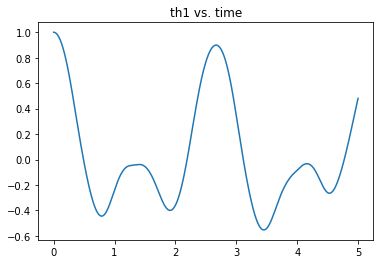

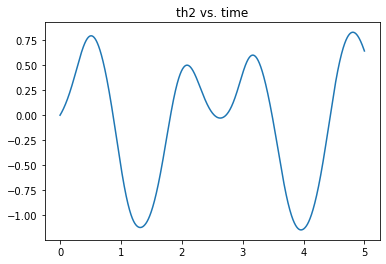

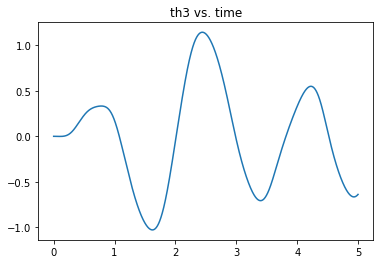

In [4]:
# Plot all theta values over time:
plt.plot(time, th1_vec)
plt.title("th1 vs. time")
plt.show()
plt.plot(time, th2_vec)
plt.title("th2 vs. time")
plt.show()
plt.plot(time, th3_vec)
plt.title("th3 vs. time")
plt.show()

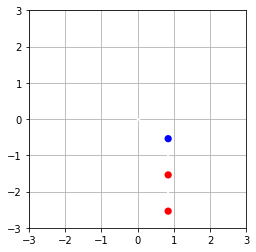

In [5]:
# from IPython.core.display import display, HTML
# import matplotlib.animation as animation

# # create an animation of the pendulum swining with Matplotlib
# def pend_pos1(tht1):
#   return x1.subs({l1:l1p, theta1:tht1}), y1.subs({l1:l1p, theta1:tht1})
# def pend_pos2(tht1, tht2):
#   return x2.subs({l1:l1p, theta1:tht1, l2:l2p, theta2:tht2}), y2.subs({l1:l1p, theta1:tht1, l2:l2p, theta2:tht2})
# # create figure
# fig = plt.figure()
# ax = fig.add_subplot(aspect='equal')
# ax.set_xlim(-l_1-l_2-l_3, l_1+l_2+l_3)
# ax.set_ylim(-l_1-l_2-l_3, l_1+l_2+l_3)
# ax.grid()

# # print(len(x1))
# line1, = ax.plot([], [], lw=2, c='w')
# line2, = ax.plot([], [], lw=2, c='w')
# line3, = ax.plot([], [], lw=2, c='w')

# circle1 = ax.add_patch(plt.Circle((0,0), 0.1, fc='b', zorder=3))
# circle2 = ax.add_patch(plt.Circle((0,0), 0.1, fc='r', zorder=3))
# circle3 = ax.add_patch(plt.Circle((0,0), 0.1, fc='r', zorder=3))


# # animate each frame "i"
# def animate(i):
#     line1.set_data([0, x1_vec[i]], [0, y1_vec[i]])
#     line2.set_data([x1_vec[i], x2_vec[i]], [y1_vec[i], y2_vec[i]])
#     line3.set_data([x2_vec[i], x3_vec[i]], [y2_vec[i], y3_vec[i]])
#     circle1.set_center((x1_vec[i], y1_vec[i]))
#     circle2.set_center((x2_vec[i], y2_vec[i]))
#     circle3.set_center((x3_vec[i], y3_vec[i]))

# # save a video: 30 fps
# ani = animation.FuncAnimation(fig, animate, frames=sim_length, interval = dt*1000.0)
# # ffmpeg_writer = animation.FFMpegWriter(fps=fp)
# myvid = ani.to_html5_video()


# display(HTML(myvid))
# # ani.save('pend.mp4', writer=ffmpeg_writer)

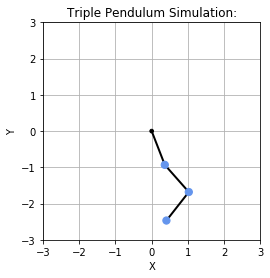

In [23]:

# Create Animation:
# Setup Figure: Initialize Figure / Axe Handles
lb, ub = -5, 5
fig = plt.figure()
ax = fig.add_subplot(aspect='equal')
ax.set_xlim(-l_1-l_2-l_3, l_1+l_2+l_3)
ax.set_ylim(-l_1-l_2-l_3, l_1+l_2+l_3)
ax.grid()
ax.set_xlabel('X')  # X Label
ax.set_ylabel('Y')  # Y Label
ax.set_title('Triple Pendulum Simulation:')
video_title = "simulation"

# Setup Animation Writer:
FPS = 20
sample_rate = int(1 / (dt * FPS))
dpi = 300
writerObj = FFMpegWriter(fps=FPS)

# Initialize Patch: Pendulum 1 and 2
pendulum_1 = Circle((0, 0), radius=0.1, color='cornflowerblue', zorder=10)
pendulum_2 = Circle((0, 0), radius=0.1, color='cornflowerblue', zorder=10)
pendulum_3 = Circle((0, 0), radius=0.1, color='cornflowerblue', zorder=10)
ax.add_patch(pendulum_1)
ax.add_patch(pendulum_2)
ax.add_patch(pendulum_3)

p1, = ax.plot([], [], color='black', linewidth=2)
p2, = ax.plot([], [], color='black', linewidth=2)
p3, = ax.plot([], [], color='black', linewidth=2)

# Draw Static Objects:
pin_joint = Circle((0, 0), radius=0.05, color='black', zorder=10)
ax.add_patch(pin_joint)

# Plot and Create Animation:
with writerObj.saving(fig, video_title+".mp4", dpi):
    for i in range(0, sim_length, sample_rate):
        # Draw Pendulum Arm:
        x_pendulum_arm_1 = [0, x1_vec[i]]
        y_pendulum_arm_1 = [0, y1_vec[i]]
        x_pendulum_arm_2 = [x1_vec[i], x2_vec[i]]
        y_pendulum_arm_2 = [y1_vec[i], y2_vec[i]]
        x_pendulum_arm_3 = [x2_vec[i], x3_vec[i]]
        y_pendulum_arm_3 = [y2_vec[i], y3_vec[i]]
        p1.set_data(x_pendulum_arm_1, y_pendulum_arm_1)
        p2.set_data(x_pendulum_arm_2, y_pendulum_arm_2)
        p3.set_data(x_pendulum_arm_3, y_pendulum_arm_3)
        # Update Pendulum Patches:
        pendulum_1_center = x1_vec[i], y1_vec[i]
        pendulum_2_center = x2_vec[i], y2_vec[i]
        pendulum_3_center = x3_vec[i], y3_vec[i]

        pendulum_1.center = pendulum_1_center
        pendulum_2.center = pendulum_2_center
        pendulum_3.center = pendulum_3_center
        # Update Drawing:
        fig.canvas.draw()
        # Grab and Save Frame:
        writerObj.grab_frame()
from IPython.display import Video
# myvid = ani.to_html5_video()

# display(HTML(myvid))
# Video("/work/"+video_title+".mp4", embed=True, width=640, height=640)